# Установка пакетов/библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn import metrics
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Аналитическая обработка данных

* Целю данной работы является предварительный анализ и подготовка данных, предназначенных для дальнейшего решения задачи оценки активов того или иного предприятия или компании. В качестве модельного датасета были выбраны данные о банкротстве ряда компаний из Тайваньского экономического журнала за 2009–2019 годы.  Банкротство было определено на основе правил ведения бизнеса Тайваньской фондовой биржи. 

* Предварительная обработка данных – это процесс подготовки необработанных данных и придания им пригодности для модели машинного обучения.


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Last Курсач/data.csv')
df.columns = ['Bankrupt'] + ['X{}'.format(x) for x in range(1, len(df.columns))]

In [4]:
df.head()

,Bankrupt,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


## 1. Первичная проверка точности модели

Как уже было упомянуто, в качестве примера для решения задачи оценки активов была выбрана задача по прогнозированию банкротства компании – присвоение ряду данных признака «банкрот» или «не банкрот», что является классификацией. 

Зачастую, для оценки модели используется базовая метрика Accuracy, которая определяет соотношение всех правильно предсказанных категорий к общему количеству всех предсказаний. Но непосредственно для задачи классификации важны и такие метрики, как Recall, Precision и F1.

In [5]:
reg,acc,rec,F1,prec,t = [], [], [], [], [], []

def make_model(df, name = ''):
  results = pd.DataFrame(columns = ['stage'])
  X = df.drop(['Bankrupt'], axis = 1)
  y = df.Bankrupt
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

  KNC = KNeighborsClassifier()
  start_time = time.time()
  KNC.fit(x_train, y_train)
  y_pred = KNC.predict(x_test)
  
  t.append(time.time() - start_time)
  reg.append(name)
  acc.append(metrics.accuracy_score(y_test, y_pred))
  prec.append(metrics.precision_score(y_test, y_pred, average="macro"))
  rec.append(metrics.recall_score(y_test, y_pred, average="macro"))
  F1.append(metrics.f1_score(y_test, y_pred, average="macro"))

  results['stage'] = reg
  results['accuracy_to_max'] = acc
  results['recall_to_max'] = rec
  results['F1_to_max'] = F1
  results['precision_to_min'] = prec
  results['time'] = t
  return results





---


В представленной для решения задаче оценки активов компаний для нас важно не упустить банкрота и ложно не присвоить ему признак финансово успешной компании. А значит, что **бо’льшее количество ложно-положительных (False Positives)** предсказаний модели будет предпочтительнее бо’льшего числа ложно-отрицательных (False Negatives). Из чего следует, что вместе с высоким значением Accuracy и F1 следует добиваться превалирования Recall над Precision.

---



In [6]:
make_model(df, name = 'Исходные данные')

,stage,accuracy_to_max,recall_to_max,F1_to_max,precision_to_min,time
0,Исходные данные,0.964809,0.510037,0.511038,0.732746,0.527067


## 2. Описательная статистика: размер, типы переменных, пустые значения, уникальные имена и дубликаты



*   **Целевая переменная** - статус компании (банкрот/ не банкрот)
*   **Основная задача** - классификация



---
Реальные данные часто являются неполными, непоследовательными, им не хватает определенного поведения или тенденций и, вероятно, содержат много ошибок. Чтобы лучше визуализировать и извлечь скрытый шаблон, необходимо выполнить предварительную обработку данных.


---

Рассмотрим ряд базовых наиболее эффективных приемов при работе с данными:



In [7]:
df.shape # размер

(6819, 96)

In [8]:
#df.info() # информация о типе данных и количестве пропусков

In [9]:
def nulls_table(df):        # проверка количества пропусков
  gg = df.isnull().sum()/len(df)*100
  dd = pd.DataFrame({'column':gg.index, 'nulls_%': gg.values}).sort_values(by = 'nulls_%', ascending=False)
  return dd[dd['nulls_%']>0]

nulls_table(df)

,column,nulls_%


При наличии недостающих значений мы использовали бы их замену на среднее значение (в случае с числовыми данными) или медиану (для категориальных переменных)

In [10]:
df.duplicated().sum() # наличие дубликатов

0

In [11]:
# Удаление неинформативных признаков с помощью поиска уникальных значений
to_del = []
for col in df.columns:
  if len(df[col].unique()) == 1:
    to_del.append(col)

to_del

['X94']

In [12]:
df = df.drop(to_del, axis = 1)

In [13]:
make_model(df, name = '-первичная обработка')

,stage,accuracy_to_max,recall_to_max,F1_to_max,precision_to_min,time
0,Исходные данные,0.964809,0.510037,0.511038,0.732746,0.527067
1,-первичная обработка,0.969208,0.511439,0.514903,0.651972,0.272950


Accuracy выше 90% и, кажется, что при построении модели без какой-либо первичной обработки мы получили, относительно, неплохую модель. Однако, метрики Recall и F1, которые являются ключевыми для нашей задачи, не говорят о высокой точности. 

## Сбалансированность данных

Учитывая задачу проекта, и теперь, когда у наc есть общий обзор наших данных, необходимо cоcредоточить внимание на признаке, который мы планируем предcказывать, а именно, определить какое количеcтво компаний является финанcово cтабильными и неcтабильными. Построим гистограмму по прогнозируемому признаку и оценим согласованность данных.

In [14]:
print(df['Bankrupt'].value_counts())
print('-'* 30)
print('Финансово стабильные компании: ', round(df['Bankrupt'].value_counts()[0]/len(df) * 100, 2), '% от данных')
print('Финансово не стабильные компании: ', round(df['Bankrupt'].value_counts()[1]/len(df) * 100, 2), '% от данных')

0    6599
1     220
Name: Bankrupt, dtype: int64
------------------------------
Финансово стабильные компании:  96.77 % от данных
Финансово не стабильные компании:  3.23 % от данных


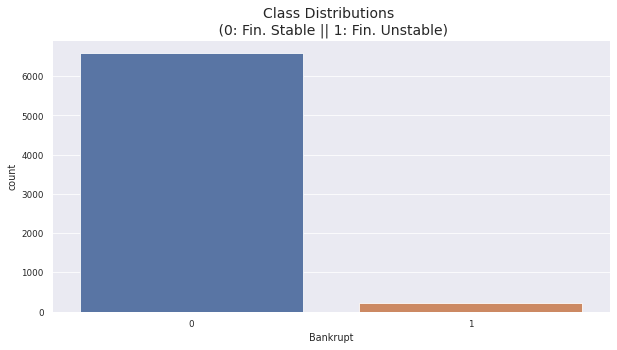

In [15]:
sns.set_theme(context = 'paper')
plt.figure(figsize = (10,5))
sns.countplot(df['Bankrupt'])
plt.title('Class Distributions \n (0: Fin. Stable || 1: Fin. Unstable)', fontsize=14)
plt.show()

Замечаем, что реальные данные плохо сбалансированы (96.77 % финансово стабильных компаний против 3.23 % банкротов). Это означает, что при решении задачи регрессии модель будет наивно предсказывать класс большинства, а значит, в дальнейшем, данную ситуацию следует обязательно предотвратить.

## 3. Удаление выбросов

Визуально оценим отклонения в рядах данных всех имеющихся признаков с помощью построения гистограмм и боксплотов:

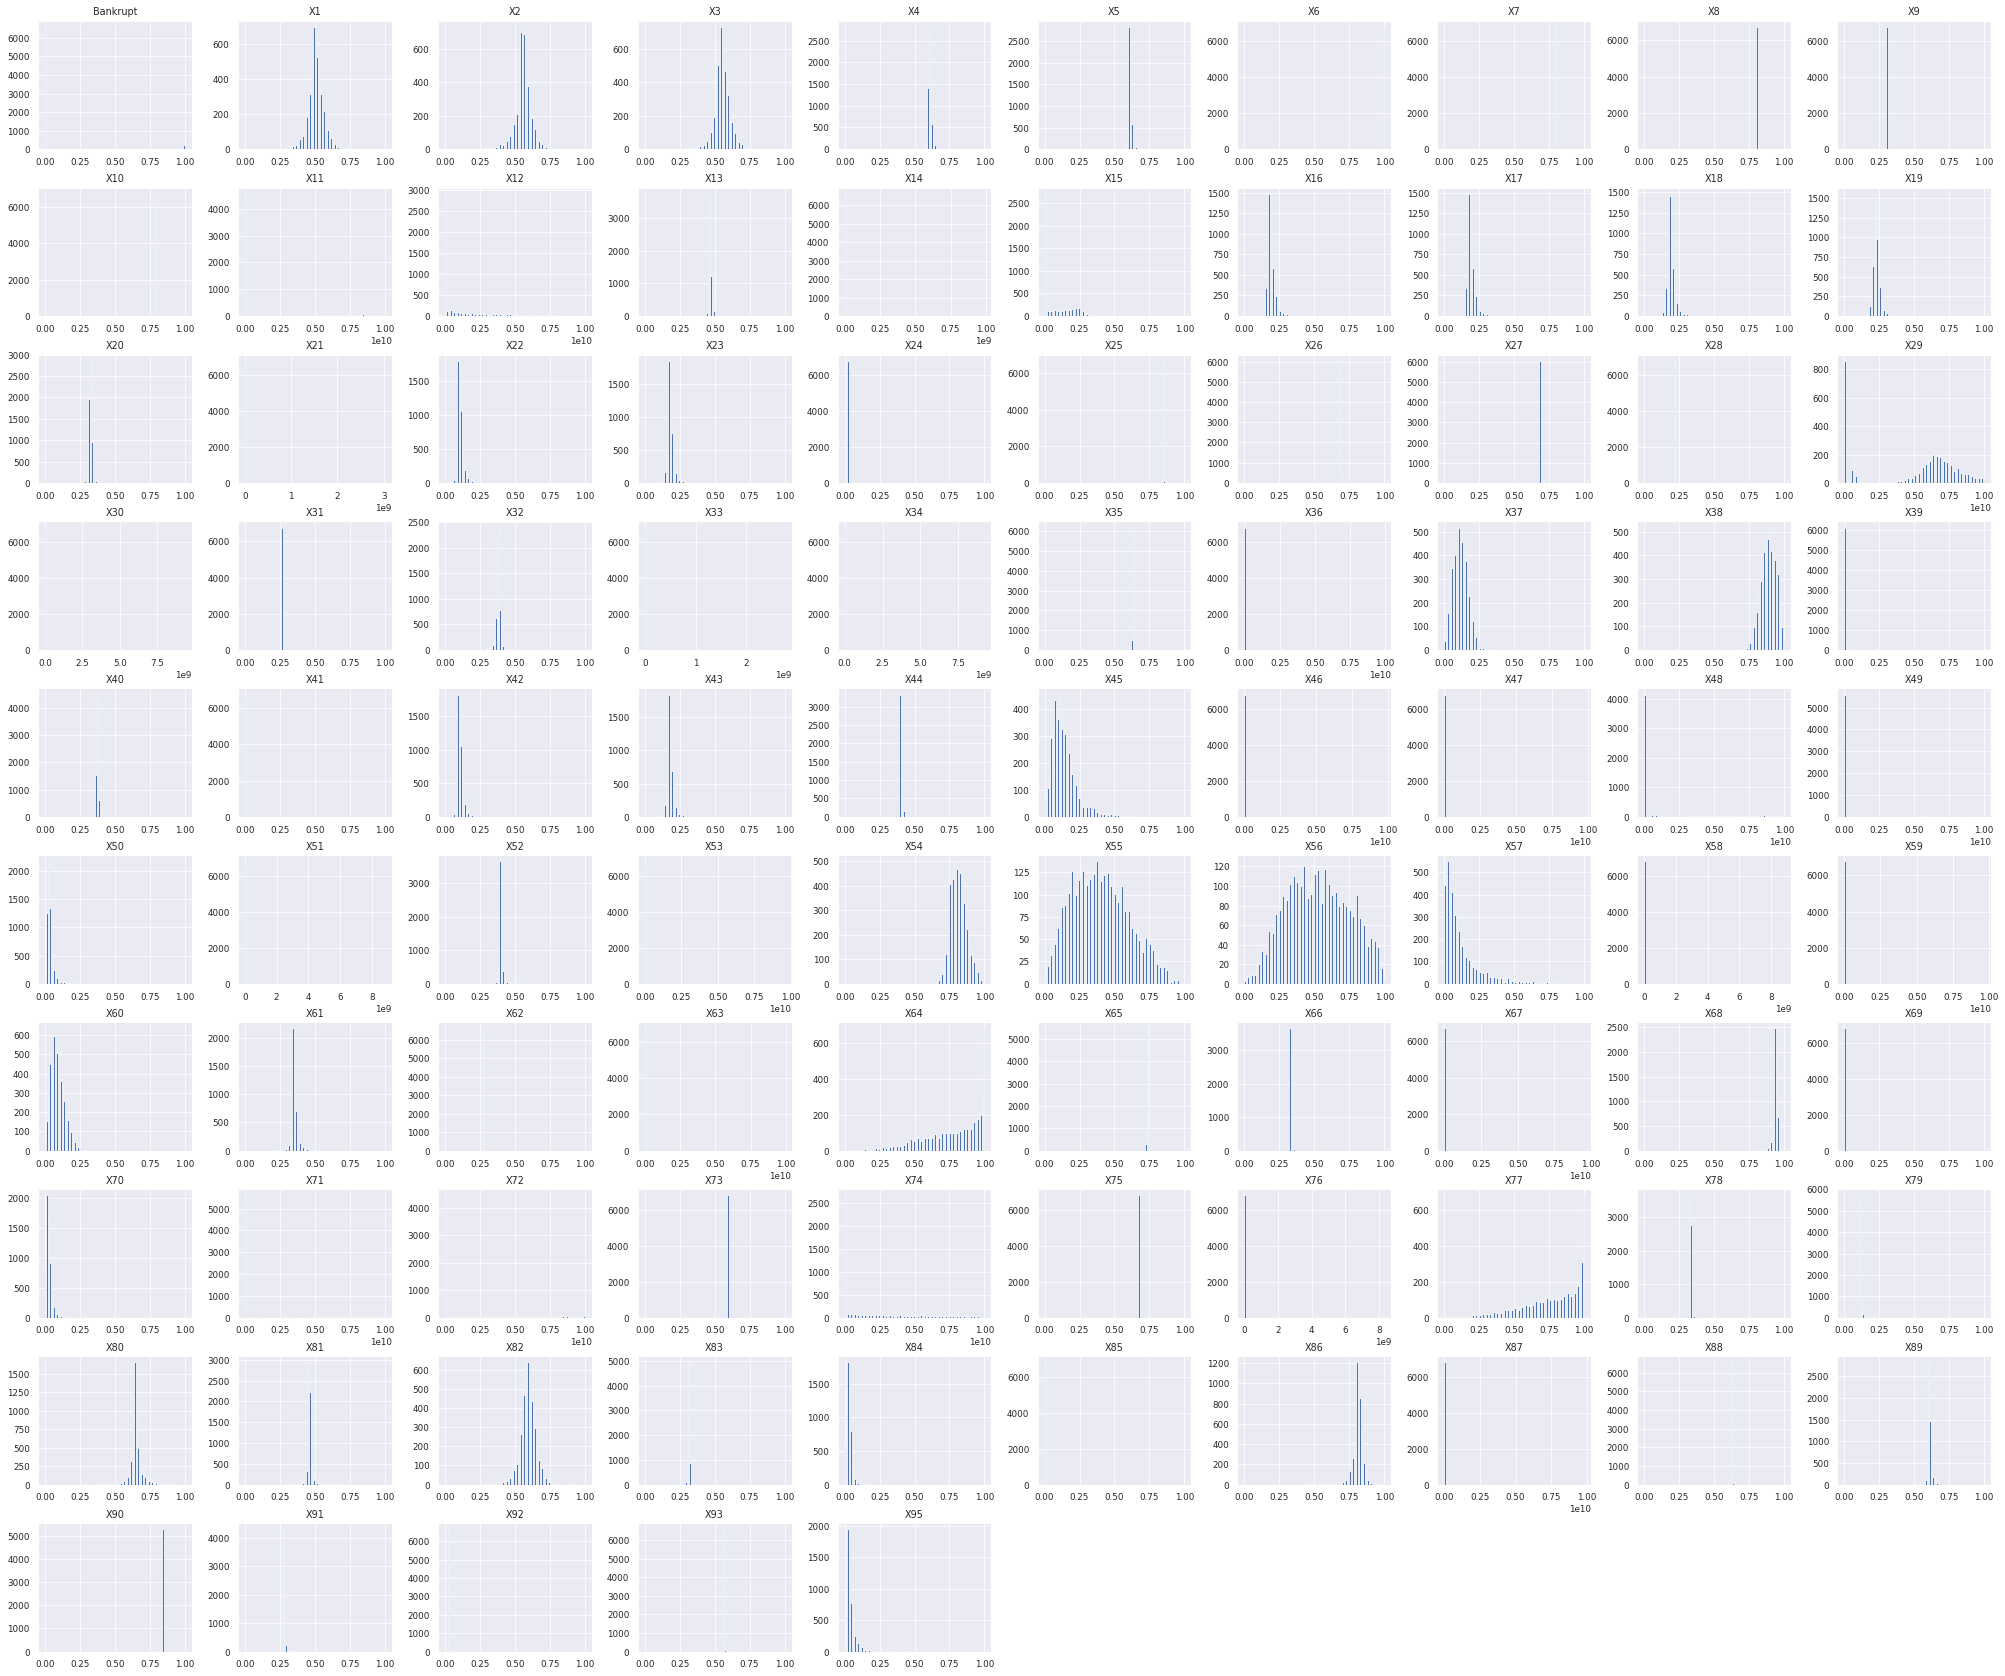

In [16]:
df.hist(figsize = (35,30), bins = 100)
plt.show() # Гистрограммы признаков

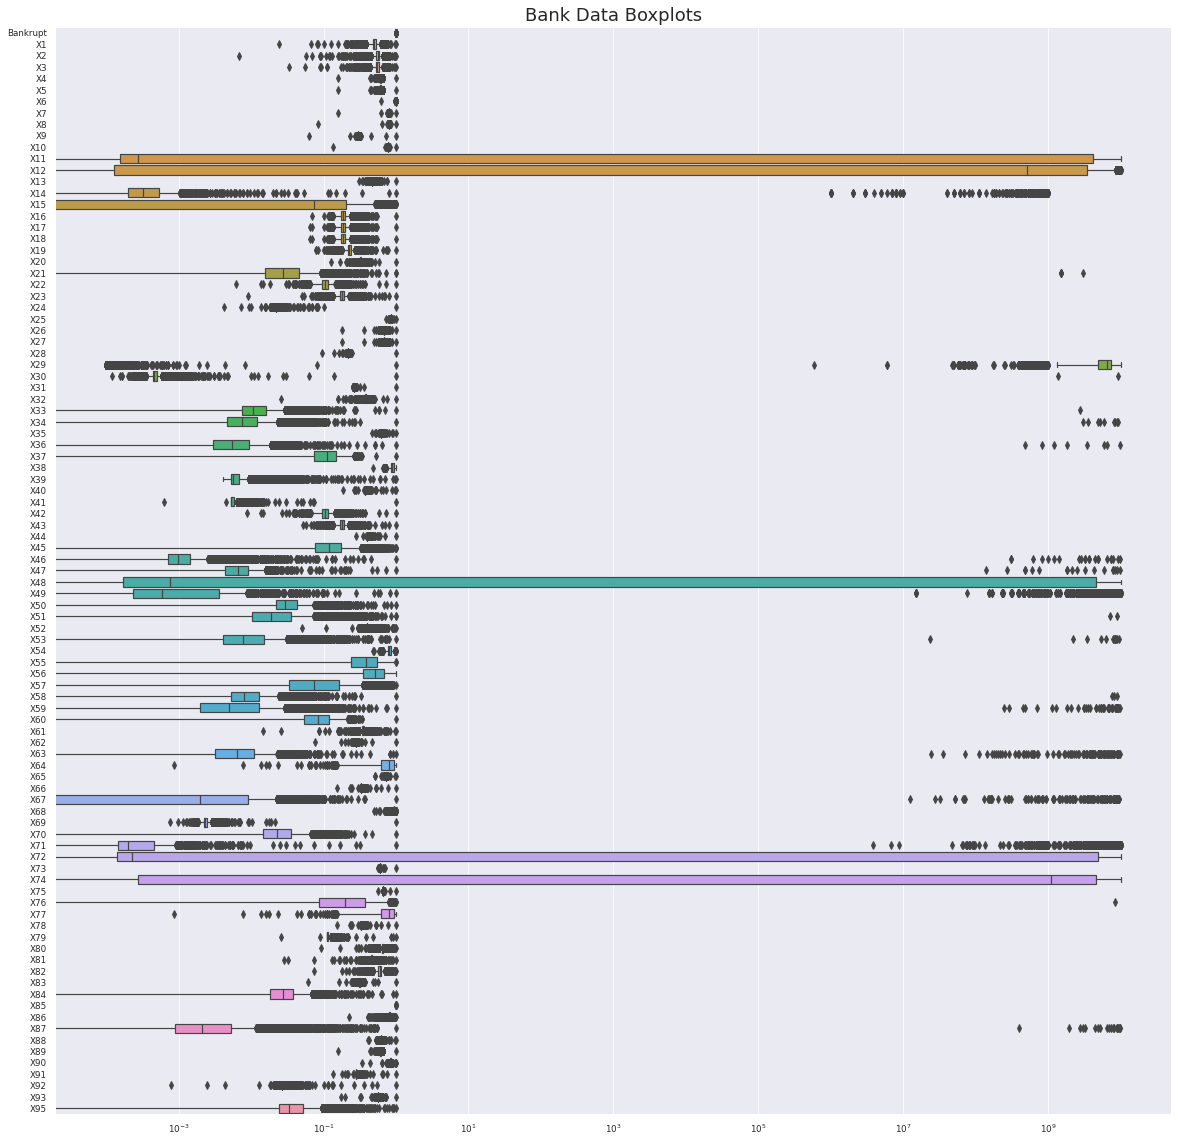

In [17]:
plt.figure(figsize = (20,20))
ax =sns.boxplot(data = df, orient="h")
ax.set_title('Bank Data Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show() # Ящики с усами (боксплоты)

Очевидно, что в сырых данные большое количество выбросов 

Избавимся от них при помощи расчета нижнего и верхнего квантилей и удалим

In [18]:
def outliers_removal(feature,feature_name,dataset):
    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    #print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
    urange = q75 - q25
    #print('urange: {}'.format(urange))
    
    feat_cut_off = urange * 1.5
    feat_lower, feat_upper = q25 - feat_cut_off, q75 + feat_cut_off
    #print(feature_name +' Lower: {}'.format(feat_lower))
    #print(feature_name +' Upper: {}'.format(feat_upper))

    df.loc[df[feature_name] > feat_upper, feature_name] = np.nan
    df.loc[df[feature_name] < feat_lower, feature_name] = np.nan
    #print('-' * 65)
    return dataset

In [19]:
for col in df.loc[:, df.columns != 'Bankrupt']:
    new_df = outliers_removal(df[col], str(col), df)

In [20]:
nulls_table(df) # процент отсутствующих значений

,column,nulls_%
92,X92,22.041355
93,X93,20.838833
49,X49,20.794838
71,X71,20.516205
29,X29,20.252236
...,...,...
64,X64,0.586596
38,X38,0.439947
37,X37,0.439947
85,X85,0.117319


In [21]:
rows = df.shape[0]
columns = df.shape[1]

# удалим строки, в которых количество NaN элементов превышает 20% общего объема данных
df = df.dropna(thresh = round(columns*0.8, 0)).reset_index(drop=True)
# удалим столбцы, в которых количество NaN элементов превышает 20% общего объема данных
df = df.dropna(axis = 1, thresh = round(rows*0.8, 0))

df.shape

(6287, 84)

In [22]:
nulls_table(df)

,column,nulls_%
27,X28,13.233657
24,X25,12.979163
25,X26,12.899634
26,X27,12.883728
68,X75,12.613329
...,...,...
49,X54,0.556704
55,X60,0.524893
70,X77,0.493081
58,X64,0.493081


Для восстановления пропусков в оставшихся данных используем замену числовых признаков на среднее

In [23]:
for i in df.columns:
    df[i] = df[i].fillna(df[i].mean()) 

In [24]:
nulls_table(df)

,column,nulls_%


In [25]:
'''plt.figure(figsize = (20,20))
ax =sns.boxplot(data = df, orient="h")
ax.set_title('Bank Data Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show() # Ящики с усами (боксплоты)'''

'plt.figure(figsize = (20,20))\nax =sns.boxplot(data = df, orient="h")\nax.set_title(\'Bank Data Boxplots\', fontsize = 18)\nax.set(xscale="log")\nplt.show() # Ящики с усами (боксплоты)'

In [26]:
# Снова проверим и удалим неинформативные признаки с помощью поиска уникальных значений (тк после удаления выбрасов и замены пропусков такие признаки могли появиться)
to_del = []
for col in df.columns:
  if len(df[col].unique()) == 1:
    to_del.append(col)

to_del

['X85']

In [27]:
df = df.drop(to_del, axis = 1)

In [28]:
make_model(df, name = '-выбросы и пропуски')

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,stage,accuracy_to_max,recall_to_max,F1_to_max,precision_to_min,time
0,Исходные данные,0.964809,0.510037,0.511038,0.732746,0.527067
1,-первичная обработка,0.969208,0.511439,0.514903,0.651972,0.272950
2,-выбросы и пропуски,0.976153,0.500000,0.493966,0.488076,0.285265


Новые метрики указывают на то, что мы двигаемся в правильном направлении, ведь качество предсказательной способности модели растет и precision уменьшается.


## 4. Коррелирующие признаки

При наличии мультиколлинеарности значимость отдельных коэффициентов регрессии уменьшается, так как стандартные ошибки становятся больше, что приводит к меньшей надежности полученных оценок. 

Построим корреляционную матрицу:

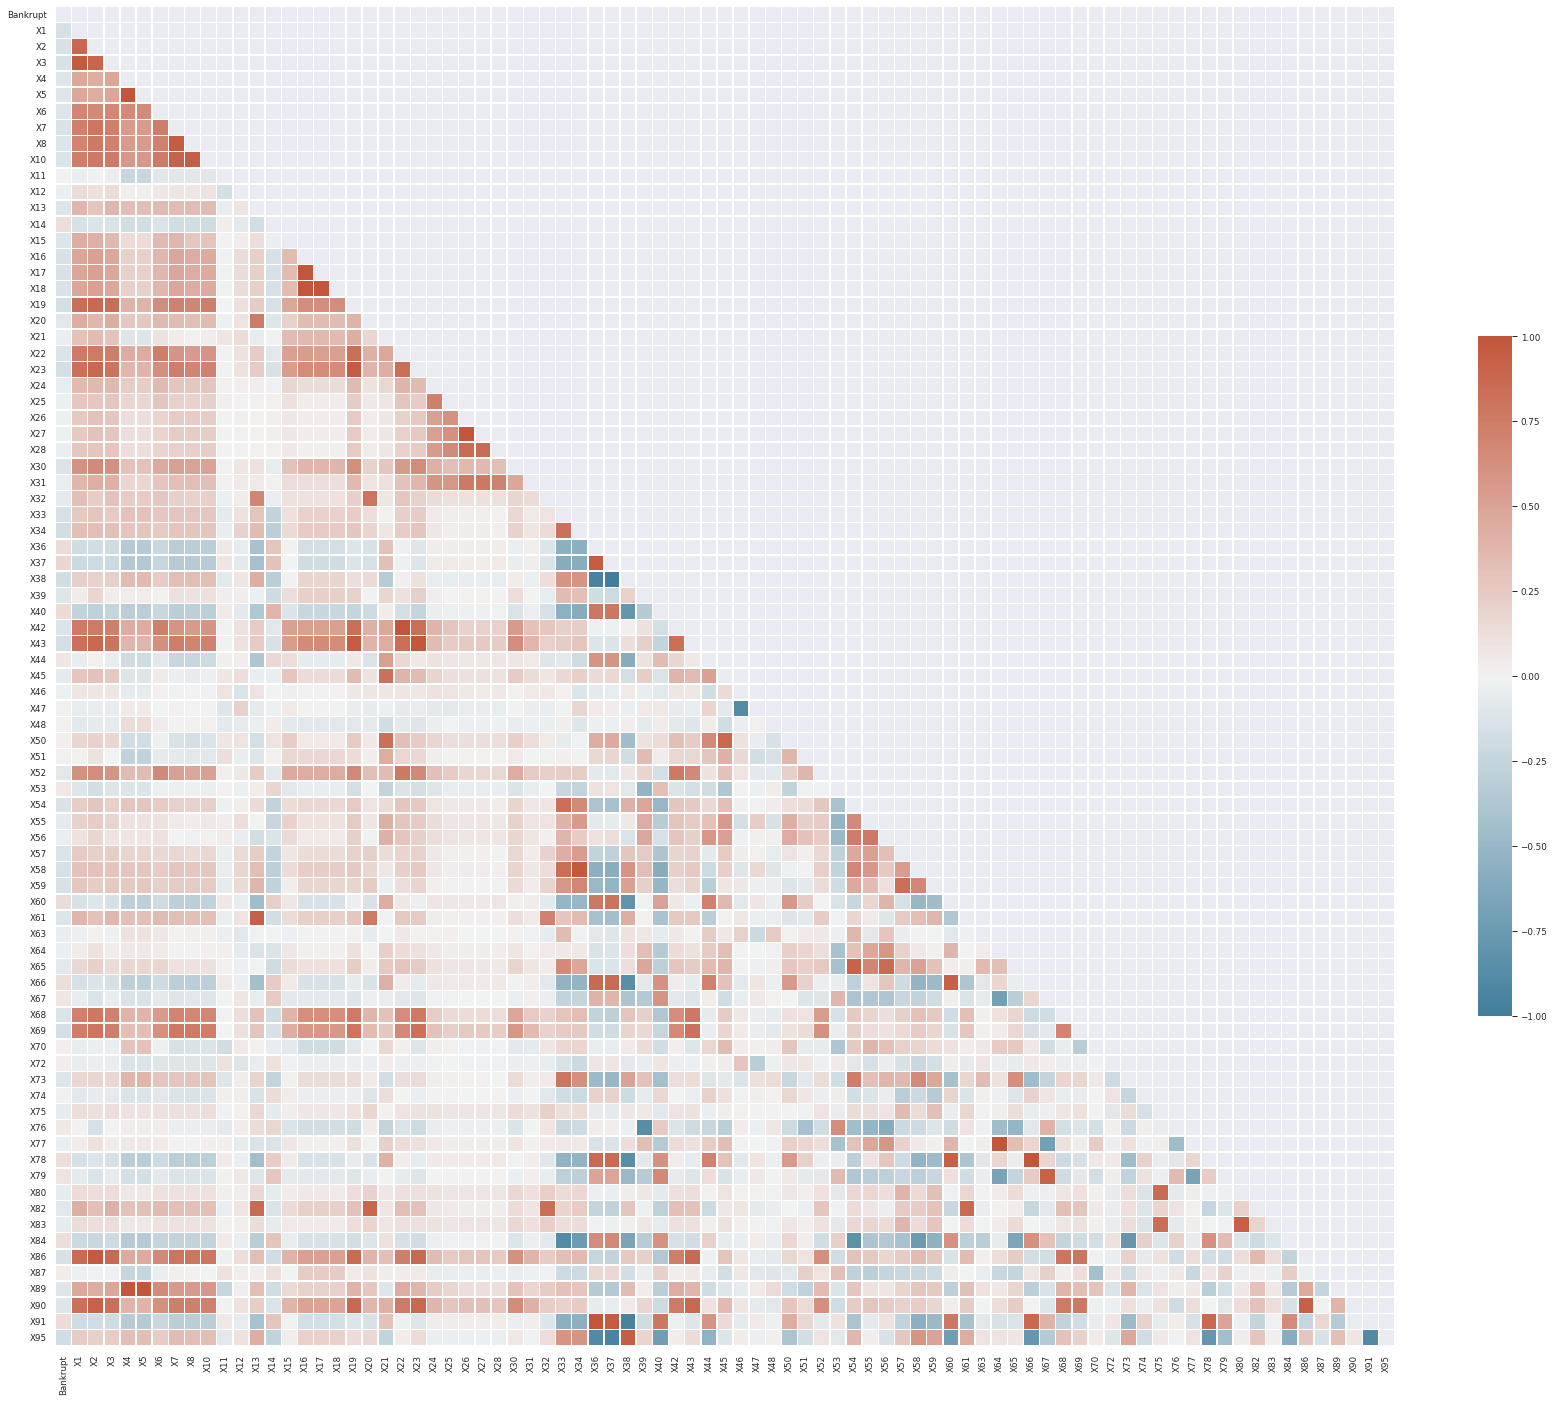

In [29]:
f, ax = plt.subplots(figsize=(30, 25))
mat = df.corr('spearman')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Отбросим объекты со значением корреляции больше 0,8

In [30]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

<ipython-input-30-f5b1a5ec98f5>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [31]:
df.shape

(6287, 83)

In [32]:
len(to_drop)

29

In [33]:
nulls_table(df)

,column,nulls_%


In [34]:
# Удаляем коррелирующие признаки
df = df.drop(to_drop, axis = 1)
df.shape

(6287, 54)

In [35]:
make_model(df, name = '-коррелирующие признаки')

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,stage,accuracy_to_max,recall_to_max,F1_to_max,precision_to_min,time
0,Исходные данные,0.964809,0.510037,0.511038,0.732746,0.527067
1,-первичная обработка,0.969208,0.511439,0.514903,0.651972,0.272950
2,-выбросы и пропуски,0.976153,0.500000,0.493966,0.488076,0.285265
3,-коррелирующие признаки,0.976153,0.500000,0.493966,0.488076,0.238575


Построив модель, убеждаемся в том, что избавление от коррелирующих признаков, в целом, позволяет добиться улучшения модели, несмотря на небольшую потерю по метрике Recall

## 5. Избавление от несбалансированности данных

Теперь, когда проведена основная работа над качеством данных, вернемся к нашей проблеме несбалансированности классов. Ведь даже после удаления некоторых строк нам не удалось добиться равновесия и, на текущий момент, финансово-нестабильных компаний почти в 46 раз больше стабильных.

In [36]:
print('Financially stable: ', round(df['Bankrupt'].value_counts()[0]/len(df) * 100, 2), '% of the dataset')
print('Financially unstable: ', round(df['Bankrupt'].value_counts()[1]/len(df) * 100, 2), '% of the dataset')

Financially stable:  97.87 % of the dataset
Financially unstable:  2.13 % of the dataset


**Для баланса и точности предсказания модели используем метод обогащения классов, создающий синтетические образцы методом SMOTE («Техника передискретизации синтетического меньшинства»)**

Он работает, создавая синтетические образцы из младшего класса вместо создания копий. Алгоритм выбирает два или более одинаковых экземпляра (используя меру расстояния) и возмущает один атрибут экземпляра за раз на случайную величину в пределах разницы с соседними экземплярами.

In [37]:
from imblearn.over_sampling import SMOTE
X = df.drop(['Bankrupt'], axis = 1)
y = df.Bankrupt
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

df = pd.concat([y, X], axis=1)
print(f'{len(df[df.Bankrupt == 1])} случаев банкротсва к {len(df[df.Bankrupt == 0])} не банкротсва')

6153 случаев банкротсва к 6153 не банкротсва


In [38]:
make_model(df, name = '-дисбаланс данных')

,stage,accuracy_to_max,recall_to_max,F1_to_max,precision_to_min,time
0,Исходные данные,0.964809,0.510037,0.511038,0.732746,0.527067
1,-первичная обработка,0.969208,0.511439,0.514903,0.651972,0.272950
2,-выбросы и пропуски,0.976153,0.500000,0.493966,0.488076,0.285265
3,-коррелирующие признаки,0.976153,0.500000,0.493966,0.488076,0.238575
4,-дисбаланс данных,0.884647,0.884590,0.884068,0.892338,0.933021


Наблюдаем, что метод искусственной генерации данных для балансировки класса позволил добиться значительного увеличения таких метрик, как recall и F1, но, вместе с этим, общая метрика Accuracy снизилась на 10%. Это может говорить нам о том, что побеждая одну проблему, всегда есть риск встретиться со второй: справившись с дисбалансом мы немного потерли в точности, однако повысили количество ложно-отрицательных 

# Работа с признаками


---


После обогащения данных в части корректировки отдельных признаков пришло время сократить количество признаков в датасете. В этом случае предлагается использование одного из методов поиска значимых (главных) компонент: первый – PCA – позволит сгруппировать все признаки в число n (выбирается пользователем), а второй – метод взаимной классификации – выберет наиболее значимые для целевой переменной среди исходных.

---


## 6.1. PCA + стандартизация

Импортируем библиотеку для изменения масштаба данных и преобразуем 53 оставшихся признака (отдельно от целевой переменной) к двадцати главным компонентам.

Перед тем, как применить РСА, необходимо отмасштабировать данные таким образом, чтобы каждый признак имел единичную дисперсию, воспользовавшись StandardScaler, так как этот метод очень чувствителен к дисперсиям исходных Признаков. Если есть большие различия между диапазонами исходных переменных, те переменные с большими диапазонами будут преобладать над остальными (например, переменная в диапазоне от 0 до 100, будет доминировать над той, что лежит в диапазоне от 0 до 1), что приведет к необъективным итогам.

In [39]:
dfff = df.copy()

In [40]:
X = dfff.drop(['Bankrupt'], axis = 1) # факторные переменные
y = dfff.Bankrupt

scaling=StandardScaler()
scaling.fit(X) 
Scaled_data=scaling.transform(X)

# преобразуем данные к двум главным компонентам
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X)
print("Форма исходного массива: {}".format(str(X.shape)))
print("Форма массива после сокращения размерности: {}".format(str(X_pca.shape)))
print("Форма: {}".format(str(y.shape)))

Форма исходного массива: (12306, 53)
Форма массива после сокращения размерности: (12306, 20)
Форма: (12306,)


Недостаток PCA заключается в том, что эти две оси графика часто бывает сложно интерпретировать. Главные компоненты соответствуют направлениям данных, поэтому они представляют собой комбинации исходных признаков. Поэтому этот метод стоит использовать только в том случае, если объяснение предикторов не является приоритетом.

In [41]:
X_pca = pd.DataFrame(X_pca)
X_pca['Bankrupt'] = y

In [42]:
make_model(X_pca, name = '-pca20')

,stage,accuracy_to_max,recall_to_max,F1_to_max,precision_to_min,time
0,Исходные данные,0.964809,0.510037,0.511038,0.732746,0.527067
1,-первичная обработка,0.969208,0.511439,0.514903,0.651972,0.272950
2,-выбросы и пропуски,0.976153,0.500000,0.493966,0.488076,0.285265
3,-коррелирующие признаки,0.976153,0.500000,0.493966,0.488076,0.238575
4,-дисбаланс данных,0.884647,0.884590,0.884068,0.892338,0.933021
5,-pca20,0.878554,0.879333,0.878209,0.884688,0.578098


Теперь вернемся с данным, полученным до преобразований PCA и посмотрим, насколько изменятся метрики качества будущей модели, если мы будем исключать незначимые признаки, а не добиваться точности путем смешения существующих признаков.

## 6.2. Mетод взаимной классификации для определения наиболее значимых признаков

Воспользуемся методом взаимной классификации признаков для измерения зависимости функций от целевого значения «Bankrupt»

Метод mutual_info_classif вычисляет взаимную информационную ценность для каждой из независимых переменных по отношению к зависимой переменной и выбирает те, которые имеют наибольший информационный прирост. Иными словами, он в основном измеряет зависимость функций от целевого значения. На выходе определяется рейтинг (балл) значимости каждой переменной.

In [48]:
X = df.drop(['Bankrupt'], axis = 1) # факторные переменные
y = df.Bankrupt

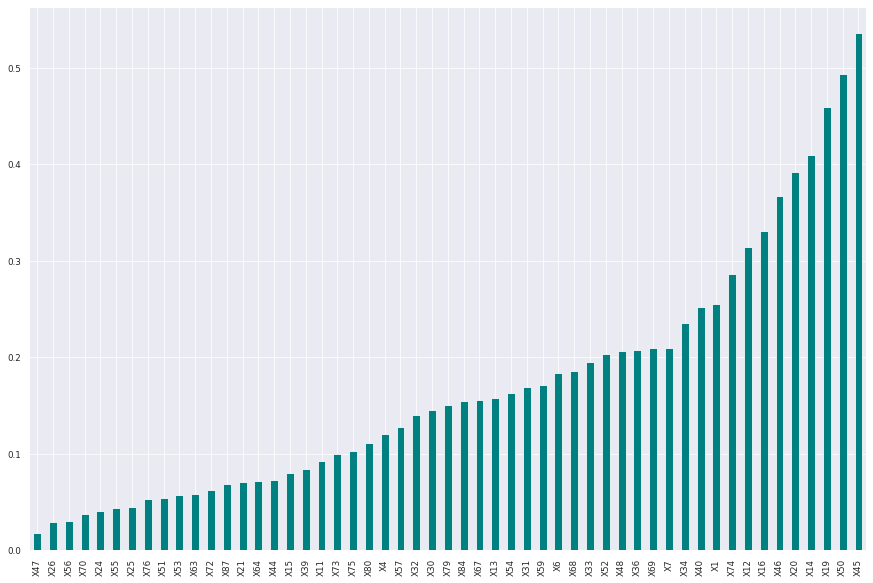

In [49]:
from sklearn.feature_selection import mutual_info_classif

plt.figure(figsize = (15,10))
importances = mutual_info_classif(X, y)
feature_importances = pd.Series(importances, X.columns[0:len(df.columns)-1]).sort_values()
feature_importances.plot(kind='bar', color='teal')
plt.show()

Выведем на экран отдельный датафрейм, в виде: «признак» - «коэффициент значимости». Сократим используемый датасет до признаков, значимость которых выше 5%.

In [50]:
feature_importances = pd.DataFrame({'column':feature_importances.index, 'imortance': feature_importances.values}).sort_values(by = 'imortance')
feature_importances.head()

,column,imortance
0,X47,0.017926
1,X26,0.029045
2,X56,0.030373
3,X70,0.037493
4,X24,0.041192


In [51]:
# Удалим совсем незначимые признаки (важность > 0.5)
unimportant_features = list(feature_importances[feature_importances.imortance < 0.05].column)
unimportant_features

['X47', 'X26', 'X56', 'X70', 'X24', 'X55', 'X25']

In [52]:
df = df.drop(unimportant_features, axis = 1)

In [53]:
df.shape

(12306, 47)

In [54]:
make_model(df, name = '-незначимые признаки')

,stage,accuracy_to_max,recall_to_max,F1_to_max,precision_to_min,time
0,Исходные данные,0.964809,0.510037,0.511038,0.732746,0.527067
1,-первичная обработка,0.969208,0.511439,0.514903,0.651972,0.272950
2,-выбросы и пропуски,0.976153,0.500000,0.493966,0.488076,0.285265
3,-коррелирующие признаки,0.976153,0.500000,0.493966,0.488076,0.238575
4,-дисбаланс данных,0.884647,0.884590,0.884068,0.892338,0.933021
5,-pca20,0.878554,0.879333,0.878209,0.884688,0.578098
6,-незначимые признаки,0.889115,0.888958,0.888626,0.895640,0.716787


Отметим, что крайний этап преобразования данных был проведен без предварительного применения метода РСА. Это значит, что, сравнив метрики двух последних наблюдений, мы можем определить какой из методов работы с признаками наиболее эффективный и позволяет добиться лучшей предсказательной способности будущей модели. 
Замечаем, что после работы над дисбалансом данных (п.5) оба метода по преобразованию и анализу главных компонент показали приблизительно одинаковые возросшие метрики accuracy, recall и F1, что может говорить о том, что каждых из методов полезен в анализе и может быть применен в зависимости от того, есть ли необходимость интерпретировать признаки.

# Итог

In [55]:
df.tail()

,Bankrupt,X1,X4,X6,X7,X11,X12,X13,X14,X15,...,X69,X72,X73,X74,X75,X76,X79,X80,X84,X87
12301,1,0.471144,0.597827,0.998980,0.797293,5.651672e+09,1.307227e+08,0.463789,0.000827,0.069261,...,0.002139,3.596001e+09,0.593841,7.080227e+08,0.671571,0.561574,0.117074,0.641263,0.028056,0.002703
12302,1,0.501664,0.589665,0.999039,0.797475,2.865673e-04,9.817481e+07,0.458795,0.000436,0.004928,...,0.002025,1.453540e-04,0.593951,1.535244e+08,0.671575,0.308969,0.111978,0.684514,0.037981,0.000553
12303,1,0.494225,0.609928,0.999021,0.797392,2.094719e-04,6.954546e+09,0.459132,0.000452,0.000000,...,0.002227,3.003751e-04,0.593974,4.122189e+09,0.671561,0.071978,0.114671,0.628287,0.034392,0.000792
12304,1,0.448366,0.593854,0.999014,0.797435,1.635150e-04,1.523570e+09,0.461226,0.000486,0.000000,...,0.002040,1.656243e-04,0.593915,2.071862e+09,0.671559,0.418729,0.118007,0.632150,0.047299,0.003295
12305,1,0.460982,0.596221,0.998924,0.797196,8.647769e+09,1.219352e+09,0.464714,0.000757,0.000000,...,0.002039,7.145439e+09,0.593883,9.625860e+08,0.671572,0.559091,0.122757,0.642068,0.028980,0.003961


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12306 entries, 0 to 12305
Data columns (total 47 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Bankrupt  12306 non-null  int64  
 1   X1        12306 non-null  float64
 2   X4        12306 non-null  float64
 3   X6        12306 non-null  float64
 4   X7        12306 non-null  float64
 5   X11       12306 non-null  float64
 6   X12       12306 non-null  float64
 7   X13       12306 non-null  float64
 8   X14       12306 non-null  float64
 9   X15       12306 non-null  float64
 10  X16       12306 non-null  float64
 11  X19       12306 non-null  float64
 12  X20       12306 non-null  float64
 13  X21       12306 non-null  float64
 14  X30       12306 non-null  float64
 15  X31       12306 non-null  float64
 16  X32       12306 non-null  float64
 17  X33       12306 non-null  float64
 18  X34       12306 non-null  float64
 19  X36       12306 non-null  float64
 20  X39       12306 non-null  fl